# Advanced Lane Finding Project

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
*Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [59]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
x_corner_num = 9
y_corner_num = 6
objp = np.zeros((y_corner_num*x_corner_num,3), np.float32)
objp[:,:2] = np.mgrid[0:x_corner_num, 0:y_corner_num].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (x_corner_num,y_corner_num), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (x_corner_num,y_corner_num), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imshow(write_name, img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

### Apply a distortion correction to raw images.

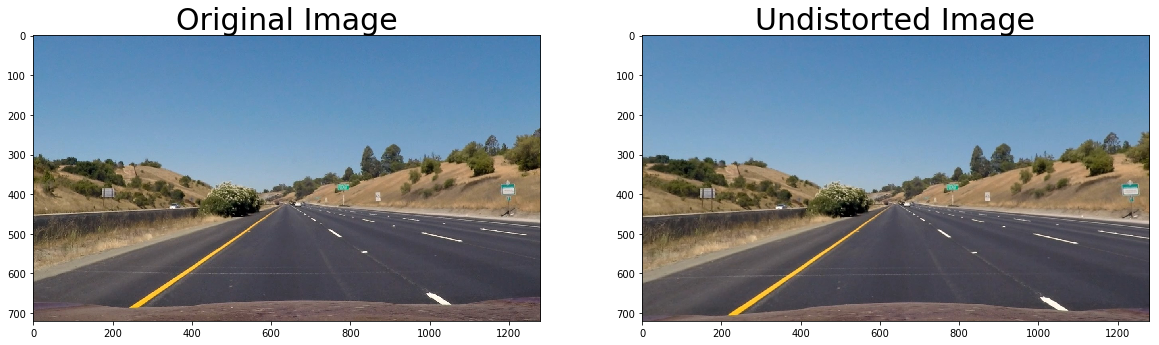

In [89]:
import pickle
%matplotlib inline

# Test undistortion on an image
#img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort an image
undist_img = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('camera_cal/undist_calibration1.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )

# Visualize undistortion
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist_img = cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=30)

### Use color transforms, gradients, etc., to create a thresholded binary image.

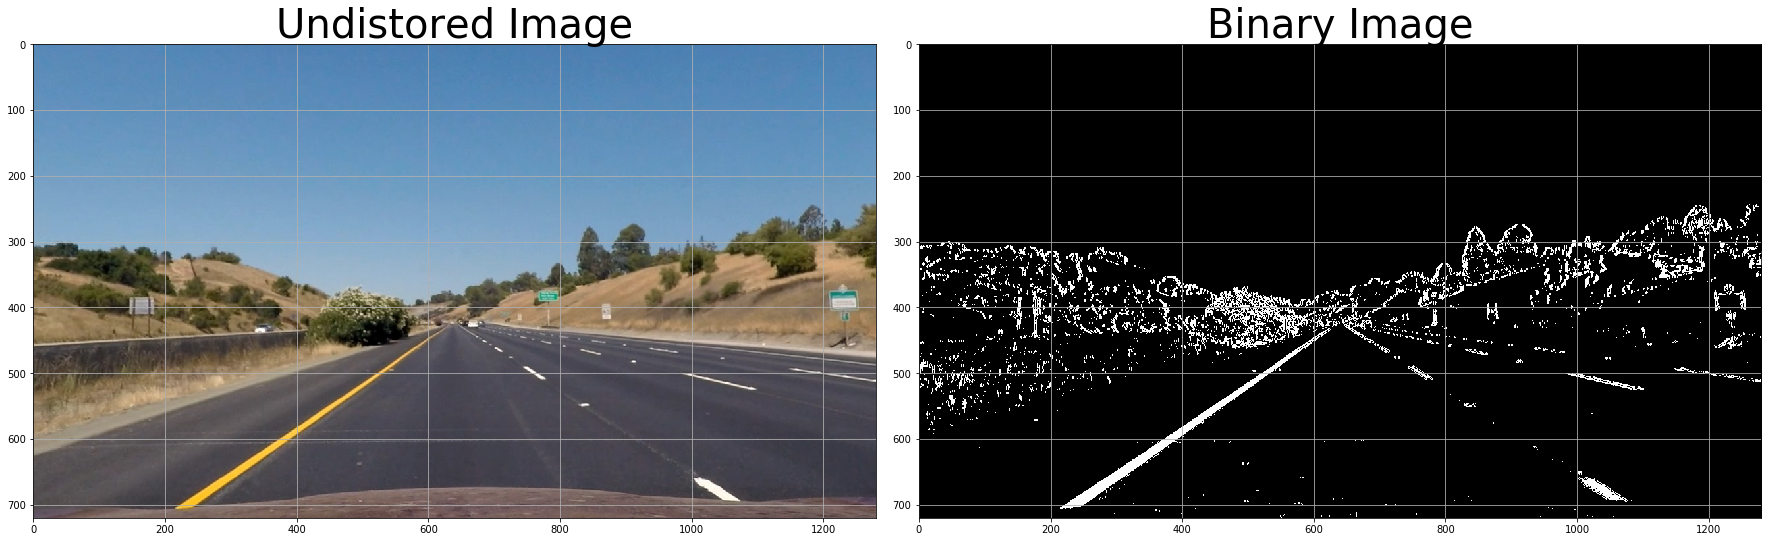

In [90]:
import matplotlib.image as mpimg

#image = mpimg.imread('test_images/test1.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    binary = np.zeros_like(sxbinary)
    binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary = 255 * np.dstack((binary, binary, binary)).astype('uint8')   
    return combined_binary
    
binary_img = pipeline(undist_img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_img)
ax1.set_title('Undistored Image', fontsize=40)
ax1.grid()

ax2.imshow(binary_img)
ax2.set_title('Binary Image', fontsize=40)
ax2.grid()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Apply a perspective transform to rectify binary image ("birds-eye view").

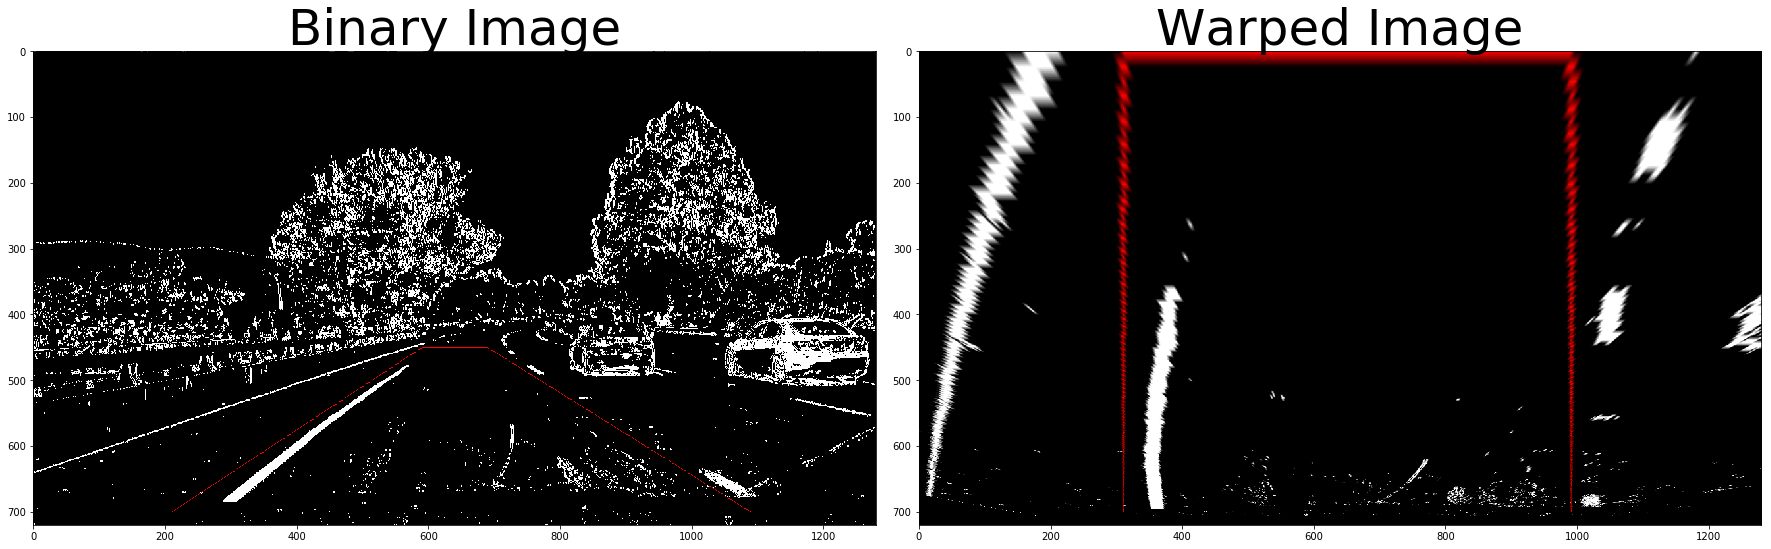

In [134]:
def warp(img, src, offset):
    dst = np.float32([[src[0,0]+offset, src[0,1]], 
                      [src[0,0]+offset, 0], 
                      [src[3,0]-offset, 0], 
                      [src[3,0]-offset, src[3,1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

# Apply perspective transform on the binary image
img = undist_img.copy()
#img = binary_img.copy()
img = mpimg.imread('test_images/test1.jpg')
img = pipeline(img)


offset = 100
src = np.float32([[210, 700], [590, 450], [690, 450], [1090, 700]])

cv2.line(img, tuple(src[0]), tuple(src[1]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[1]), tuple(src[2]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[2]), tuple(src[3]), color=[255,0,0], thickness=1)
cv2.line(img, tuple(src[3]), tuple(src[0]), color=[255,0,0], thickness=1)

top_down_img, perspective_M = warp(img, src, offset)

# Visualize top-down view
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Binary Image', fontsize=50)
ax2.imshow(top_down_img)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Detect lane pixels and fit to find the lane boundary.

### Determine the curvature of the lane and vehicle position with respect to center.

### Warp the detected lane boundaries back onto the original image.

### Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.